<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=300 height=300 align=left class="saturate" >

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2023<br>
<font color=3C99D size=5>
    Practical Assignment 3 - Reinforcement Learning <br>
<font color=696880 size=4>
    Hossein Goli

____

Danial Gharib
400105155


## Gym OpenAI Environments
`gym` is a library developed by OpenAI that provides a suite of environments for developing and comparing reinforcement learning algorithms. Each environment has a well-defined observation space and action space, as well as a reset function that returns the environment to its initial state.

The main steps involved in training an agent in a `gym` environment are:

1. Initialize the environment
2. Reset the environment to its initial state
3. Take an action in the current state
4. Observe the new state and reward
5. Update the agent's policy based on the observed reward and new state
6. Repeat steps 3 to 5 until the environment returns a "done" signal

Once the agent has learned a good policy, it can be evaluated by running it in the environment for several episodes and measuring its average reward.

### FrozenLake environment
The `FrozenLake-v1` environment is a variant of the classic reinforcement learning problem where the agent must navigate a grid while avoiding obstacles.

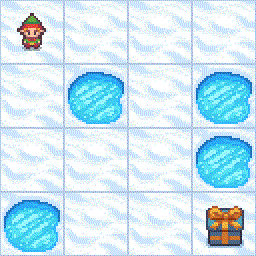


* **Observation Space:** The observation space of the environment is a grid representing the state of the lake.
* **Action Space:** The agent has four possible actions at each time step: move up, move down, move left, or move right.
* **Goal:** The goal of the agent is to reach the goal state while avoiding holes in the ice.
* **Reward:** Reach goal(G): +1 , Reach hole(H): 0 , Reach frozen(F): 0
* **Episode Termination:** The environment signals the end of an episode with a "done" signal.


In [ ]:
!pip install gymnasium

In [ ]:
import numpy as np
import gymnasium as gym
import random
from tqdm.notebook import tqdm
import gymnasium as gym
from IPython.display import HTML
from base64 import b64encode
import imageio

In [ ]:
#We first create our enviroment
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode='rgb_array')

In [ ]:
# ## comment this part if your not using google colab
# from pyvirtualdisplay import Display
# virtual_display = Display(visible=0, size=(1400, 900))
# virtual_display.start()
# ######################

def record_video(env, Qtable, out_directory, fps=1, random_action=False, max_steps=100):
    images = []
    done = False
    truncated = False
    state, info = env.reset()
    #state = discretize_state(state)
    img = env.render()
    images.append(img)
    total_reward = 0
    i = 0
    while not done and not truncated:
        i += 1
        if i > max_steps:
            break
        action = np.random.randint(4) if random_action else np.argmax(Qtable[state])
        state, reward, done, truncated, info = env.step(action)
        total_reward += reward
        #state = discretize_state(state)
        img = env.render()
        images.append(img)
        if not random_action:
            print(f"action: {action}, state: {state}, reward: {reward}, done: {done}, truncated: {truncated}, info: {info}")
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)
    return total_reward

def show_video(video_path, video_width = 600):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [ ]:
total_reward = record_video(env, None, 'frozenlake_random.mp4', fps=5, random_action=True)
print(f"total reward: {total_reward}")
show_video('frozenlake_random.mp4', video_width = 600)

total reward: 0.0


## Policy Evaluation

We call $V^\pi$(s) be the expected utility received by following policy π from state s

$V^\pi$(s) can be calculated in two ways.
First solving the Bellman Equations directly or doing it iteratively in a Dynamic Programming manner. Implement Policy Evaluation in the following function and test some policies in the given Enviroment
In the following sections calculate $V^\pi$(s) and $Q^\pi$(s,a) for the given policy

for ease of use we shall define dynamics first and then use it to calculate the value function

In [ ]:
nS = 4 * 4
nA = 4
gamma = 0.9

def define_dynamic(env):
	"""
		define the dynamic of MDP as a nested dictionary
		for each state and action return (P(s'|s, a), s', R, is_terminal)

	"""
	############################
    # YOUR IMPLEMENTATION HERE #
		############################
	dynamic = {}
	for state in range(nS):
		dynamic[state] = {}
		for action in range(nA):
			transitions = env.unwrapped.P[state][action]
			probs = [p for (p, _, _, _) in transitions]
			next_states = [next for (_, next, _, _) in transitions]
			rewards = [r for (_, _, r, _) in transitions]
			is_terminals = [isT for (_, _, _, isT) in transitions]

			dynamic[state][action] = {
					'probs' : probs,
					'next_states' : next_states,
					'rewards' : rewards,
					'is_terminals' : is_terminals
			}
	return dynamic
dynamic = define_dynamic(env)

In [ ]:
def policy_evaluation(dynamic, policy, iterations):
    """Evaluate the value function from a given policy.

    Parameters
    ----------
    dynamic: dict (nested dynamic of our MDP)
    policy: a numpy array that maps state to action
    iterations: int, number of iterations to run
    """
    value_function = np.zeros(nS)
    value_function[15] = 1
    Q_function = np.zeros((nS, nA))
    ############################
    # YOUR IMPLEMENTATION HERE #
    ############################
    for itr in range(iterations):
      value_tmp = value_function.copy()
      value_function = np.zeros(nS)
      value_function[15] = 1
      for state in range(nS):
        action = policy[state]
        updated_value = 0
        next_states = dynamic[state][action]['next_states']
        rewards = dynamic[state][action]['rewards']
        # is_terminals = dynamic[state][action]['is_terminals']
        for idx in range(len(next_states)):
          updated_value += dynamic[state][action]['probs'][idx] * (rewards[idx] + gamma * value_tmp[next_states[idx]])
        value_function[state] = updated_value
        Q_function[state, action] = updated_value



    return value_function, Q_function

In [ ]:
# we define a policy (all one) and evaluate it
policy = np.ones([nS], dtype=int)
value_function, Q_function = policy_evaluation(dynamic, policy, iterations=100)
print(Q_function)
#Visualize The Policy using record video and
total_reward = record_video(env, Q_function, 'frozenlake_policy.mp4', fps=5, random_action=False, max_steps=100)
print(f"total reward: {total_reward}")
show_video('frozenlake_policy.mp4', video_width = 600)

[[0.00000000e+00 1.88660906e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.40500774e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.79671927e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.19860440e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.99703629e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.71873678e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.99302792e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.63169516e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.23956984e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.50008854e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.83351041e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.65613989e-05 0.00000000e+00 0.000000

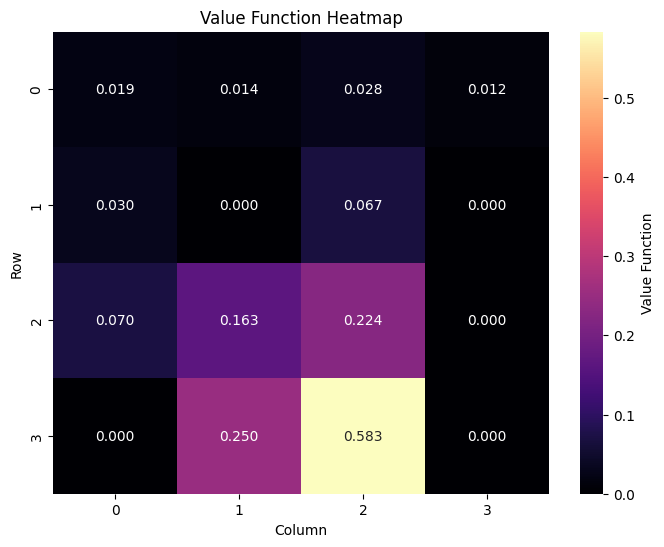

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#Show the heatmap of the value function of your test policy

value_grid = np.reshape(value_function, (int(np.sqrt(nS)), int(np.sqrt(nS))))

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(value_grid, annot=True, cmap="magma", fmt=".3f", cbar_kws={'label': 'Value Function'})
plt.title('Value Function Heatmap')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

## Q-Learning
Q-Learning is a model-free reinforcement learning algorithm that is used to find the optimal policy for an agent in an environment. It is based on the idea of updating an estimate of the optimal action-value function using the Bellman equation. The optimal action-value function is defined as the maximum expected reward that an agent can receive by taking an action a in a state s and following the optimal policy thereafter.

The action-value function Q(s,a) is updated iteratively as follows:

$$ Q(s,a) \leftarrow Q(s,a) + \alpha \left( r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right) $$

where ‍‍‍‍‍`r` is the reward received after taking action a in state `s`, `s'` is the new state, $\gamma$ is the discount factor (a value between 0 and 1 that determines the importance of future rewards), and $\alpha$ is the learning rate (determines the step size at which the value function is updated).

In [ ]:
def initialize_q_table(env):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    return q_table

In [ ]:
def epsilon_greedy_policy(q_table, state, epsilon):
    """
    This function implements the epsilon greedy policy. It takes the q_table, the current state and the epsilon value as input and returns an action.
    Inputs:
        q_table: the q_table ndarray
        state: the current state of the agent
        epsilon: the epsilon value
    Outputs:
        action: an action according to the epsilon greedy policy
    """
    ################
    #YOUR CODE HERE#
    ################
    if np.random.rand() < epsilon:
      action = np.random.choice(len(q_table[state]))
    else:
      action = np.argmax(q_table[state])
    return action


In [ ]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, learning_rate, Qtable):
  """
  This function implements the training loop. It takes the number of training episodes, the minimum epsilon, the maximum epsilon,
  the decay rate, the environment, the maximum number of steps per episode and the q_table as input and returns the trained q_table and the episode rewards.
  Inputs:
      n_training_episodes: the number of training episodes
      min_epsilon: the minimum epsilon value
      max_epsilon: the maximum epsilon value
      decay_rate: the decay rate of the epsilon value
      env: the environment
      max_steps: the maximum number of steps per episode
      Qtable: the q_table ndarray
  Outputs:
      Qtable: the trained q_table ndarray
      episode_rewards: the episode rewards
  """
  episode_rewards = []
  # learning rate
  #alpha = 0.1
  ####
  for episode in tqdm(range(n_training_episodes)):
    # Adjust epsilon
    # TODO: YOUR CODE HERE
    ###########################
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

    # Reset the environment
    # TODO: YOUR CODE HERE
    state, _ = env.reset()
    #######################

    episode_reward = 0
    # repeat
    for step in range(max_steps):
      # Select an action and perform it (take a step) then use Q-learning to update the q_table
      # TODO: YOUR CODE HERE
      ###########################
      action = epsilon_greedy_policy(Qtable, state, epsilon)
      next_state, reward, done, _, _ = env.step(action)
      Qtable[state, action] += learning_rate * (reward + gamma * np.max(Qtable[next_state]) - Qtable[state, action])
      state = next_state
      episode_reward += reward
      if done:
        break
    episode_rewards.append(episode_reward)
  return Qtable, episode_rewards

# Clif Walking

Now we are going to play with anothe envirment called Clif Walking. The agent is on a 4x12 grid, and the goal is to reach the terminal state at the end of the grid. At each step, the agent can move up, down, left, or right. The episode ends when the agent reaches the terminal state. If the agent falls into the cliff at any point, it returns to the start state.

We are going to see how different values of gamma, and different values of noise affect the performance of the agent.

In [ ]:
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
env.reset()
env.render()

# Training parameters
n_training_episodes = 1000  # Total training episodes
n_eval_episodes = 10
learning_rate = 0.1           # Learning rate

# Environment parameters
max_steps = 20               # Max steps per episode
gamma = 0.9                 # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 0.01           # Exponential decay rate for exploration prob

Qtable = np.zeros((env.observation_space.n, env.action_space.n))
Qtable_trained_QL, episode_rewards_QL = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, learning_rate, Qtable)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
record_video(env, Qtable_trained_QL, 'cliffwalking_random.mp4', fps=5, random_action=False)
show_video('cliffwalking_random.mp4', video_width = 600)


action: 0, state: 24, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 25, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 26, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 27, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 28, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 29, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 30, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 31, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 32, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 33, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 34, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 35, reward: -1, done: False, truncated: False, 

# Noisy Cliff

We create a noisy version of this environment by adding a small probability that the agent moves in a random direction instead of the intended direction. We will see how this affects the performance of the agent.

In [ ]:
class NoisyCliffWalking(gym.Env):
    def __init__(self, map_name="4x12", render_mode='rgb_array', noise=0.1):
        self.env = gym.make("CliffWalking-v0", render_mode=render_mode)
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        self.noise = noise

    def reset(self):
        return self.env.reset()

    def step(self, action):
        if random.uniform(0, 1) < self.noise:
            return self.env.step(self.action_space.sample())
        else:
            return self.env.step(action)

    def render(self):
        return self.env.render()



## Play It Safe!

Set the following hyper parameters in a mnner so that your agent tries a very safe path from the top of the board instead of near edges and when it is almost reaching the half way of the path get nearar to cliff and goal

Then Reason why this is happening Mathematically!

attention! :
i added learning rate to functions prototype

In [ ]:
env = NoisyCliffWalking(map_name="4x12", render_mode='rgb_array', noise=0.008)

# Training parameters
n_training_episodes =   10000 #???  # Total training episodes
# said there is no need for this n_eval_episodes =  1   #???
learning_rate =  0.55 #???          # Learning rate

# Environment parameters
max_steps = 99               # Max steps per episode
gamma = 0.95                # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 1e-3            # Exponential decay rate for exploration prob

**Mathematical Explanation**

When noise is less the agent perhaps tries to cut its way a bit shorter and take a risk which has less chance to fail and also increasing training episodes gives the agent a better learning chance.But i also added to learning_rate which this causes the agent to influence more on the rewards taken rather than the previous value of a certain state.All this results in taking a step down when agent has reached half or a bit more than the half of way on the top line.and afterwards resume its way with the same pattern to the goal.

In [ ]:
q_table = initialize_q_table(env)
q_table_trained_QL, episode_rewards_QL = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, learning_rate, q_table)
#i replaced this
record_video(env, q_table_trained_QL, 'cliffwalking_random.mp4', fps=5, random_action=False)
# this could not be run !!!
#record_video_frozen_lake_env(env, q_table_trained_QL, 'cliffwalking_random.mp4', fps=5, random_action=False)
show_video('cliffwalking_random.mp4', video_width = 600)

  0%|          | 0/10000 [00:00<?, ?it/s]

action: 0, state: 24, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 12, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 1, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 2, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 3, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 4, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 5, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 6, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 7, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 2, state: 19, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 20, reward: -1, done: False, truncated: False, info: {'

Set the hyper parametrs in a way it doesnt move near the cliff and doesnt use the top road which is too long and chooses the middle path!
then reason why this is happening mathematicaly!

In [ ]:
# Training parameters
env = NoisyCliffWalking(map_name="4x12", render_mode='rgb_array', noise=0.01)

n_training_episodes = 10000  # Total training episodes  ???
# n_eval_episodes = ???
learning_rate = 0.1          # Learning rate ???

# Environment parameters
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate ???

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 1e-3            # Exponential decay rate for exploration prob

In [ ]:
q_table = initialize_q_table(env)
q_table_trained_QLw, episode_rewards_QLw = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps,learning_rate ,q_table)

  0%|          | 0/10000 [00:00<?, ?it/s]

**Mathematical Explanation**

when gamma is larger the future and comming rewards get more value.Also when learning rate is lower (0.1 like here) and the number of training episodes is large (like 10000 times here) the algorithm would rather converger more gradually and slowly but in a reasonable, conforming and more rational way to the optimal policy. Which in here is going from the middle path (cause if there is a noise and we're in the down path, we could fall down the hill) but when going in the middle if ever is a noise we can after that conmpensate it by going up.Also note that the noise is 0.01 here which means the chance of a faulty action resulting in an unwanted way for two times continuously is very very trivial and nearly not possible (it is 0.01 * 0.01) so if there is a noise and we go down from second line to first line, there is really poor chance to again act noisy and go from first line to fall down the hill!

In [ ]:
#record_video_frozen_lake_env(env, q_table_trained_QLw, 'cliffwalking_random.mp4', fps=5, random_action=False)
record_video(env, q_table_trained_QLw, 'cliffwalking_random.mp4', fps=5, random_action=False)
show_video('cliffwalking_random.mp4', video_width = 600)

action: 0, state: 24, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 12, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 13, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 14, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 15, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 16, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 17, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 18, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 19, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 20, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 21, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 22, reward: -1, done: False, truncated: False, 

Set the parameters in a way that the agent moves to the top left corner andd then dont move to the goal and prefers stay there and reason why this is happening mathematically!

In [ ]:
# Training parameters
n_training_episodes = 10000  # Total training episodes ??????
learning_rate = 0.1         # Learning rate   ???????????

# Environment parameters
max_steps = 99               # Max steps per episode
gamma = 0.008               # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate =  0.1 #1e-3            # Exponential decay rate for exploration prob

In [ ]:
q_table = initialize_q_table(env)
q_table_trained_QLw, episode_rewards_QLw = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps,learning_rate, q_table)

  0%|          | 0/10000 [00:00<?, ?it/s]

**MATHEMATICAL REASON**
when gamma is very little (like here which is 0.008) it converges noticeably rapidly but not to the optimal state! but to a suboptimal state (like here for instance which is at top left the furthest possible location from down left with taking 2 steps)and the reason for this incidene is due to the formula for Q_learning which each time we're multiplying value of s' state (the state we go to) in an gamma parameter but when gamma is low soon there will be no effect of the Q(s',a') anymore (or it's really trivial)!. hence in this situation further rewards and future rewards get less and less unimportant as gamma gets lower.I also added to the decay rate which does not let the algorithm to explore very much and its chance to visit a node randomly and not according to the confirmed policy gets lower.All this together has caused the agent to choose the path to the top and get stuck there.

In [ ]:
#record_video_frozen_lake_env(env, q_table_trained_QLw, 'cliffwalking_random.mp4', fps=5, random_action=False)
record_video(env, q_table_trained_QLw, 'cliffwalking_random.mp4', fps=5, random_action=False)
show_video('cliffwalking_random.mp4', video_width = 600)

action: 0, state: 24, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 12, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 3, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 3, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 3, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 3, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 3, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 3, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 3, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 3, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 3, state: 0, reward: -1, done: False, truncated: False, info: {'pr

## SARSA
SARSA (State-Action-Reward-State-Action) is a popular reinforcement learning algorithm used for finding an optimal policy in an environment. Like Q-learning, SARSA is an on-policy algorithm that updates the values of the Q-table based on the observed rewards and next state-action pairs.

The key difference between SARSA and Q-learning is in the selection of the next action. In SARSA, the next action is selected based on the current policy, whereas in Q-learning, the next action is selected based on the greedy policy. This means that in SARSA, the algorithm is learning about the expected returns from the current policy, whereas in Q-learning, the algorithm is learning about the optimal policy.

Mathematically, the SARSA update rule can be represented as:

$$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \left( R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t) \right)$$


Where $Q(S_t,A_t)$ is the current estimate of the expected return for taking action $A_t$ in state $S_t$, $\alpha$ is the learning rate, $R_{t+1}$ is the reward received after taking action $A_t$ in state $S_t$, $\gamma$ is the discount factor, and $Q(S_{t+1},A_{t+1})$ is the estimated return for taking action $A_{t+1}$ in the next state $S_{t+1}$.


In [ ]:
#SARSA
def train_sarsa(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable, learning_rate = 0.1, gamma = 0.9):
    episode_rewards = []
    for episode in tqdm(range(n_training_episodes)):
        # Adjust epsilon
        # YOUR CODE HERE
        # Reset the environment
        # YOUR CODE HERE
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        state, _ = env.reset()
        action = epsilon_greedy_policy(Qtable, state, epsilon)
        #####################
        episode_reward = 0
        # repeat
        for step in range(max_steps):
            ######################
            # Your code here
            next_state, reward, done, _, _ = env.step(action)
            next_action = epsilon_greedy_policy(Qtable, next_state, epsilon)

            Qtable[state, action] += learning_rate * (reward + gamma * Qtable[next_state, next_action] - Qtable[state, action])
            state = next_state
            action = next_action
            episode_reward += reward
            #####################
            if done:
                break
        episode_rewards.append(episode_reward)

    return Qtable, episode_rewards


In [ ]:
q_table = initialize_q_table(env)
q_table_trained_Sarsa, episode_rewards_sarsa = train_sarsa(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table, learning_rate = 0.05, gamma = 0.9)
# record_video_frozen_lake_env(env, q_table_trained, 'cliffwalking_random.mp4', fps=5, random_action=False)
record_video(env, q_table_trained_Sarsa, 'cliffwalking_random.mp4', fps=5, random_action=False)
show_video('cliffwalking_random.mp4', video_width = 600)


  0%|          | 0/10000 [00:00<?, ?it/s]

action: 0, state: 24, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 12, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 13, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 14, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 15, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 16, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 17, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 18, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 19, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 20, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 21, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 22, reward: -1, done: False, truncated: False, 

## Compare Q Learning with SARSA

Compare the performance of Q Learning and SARSA in the Cliff Walking environment. Which algorithm performs better? Why do you think this is the case? Which is more sample efficient? Which is more computationally efficient?

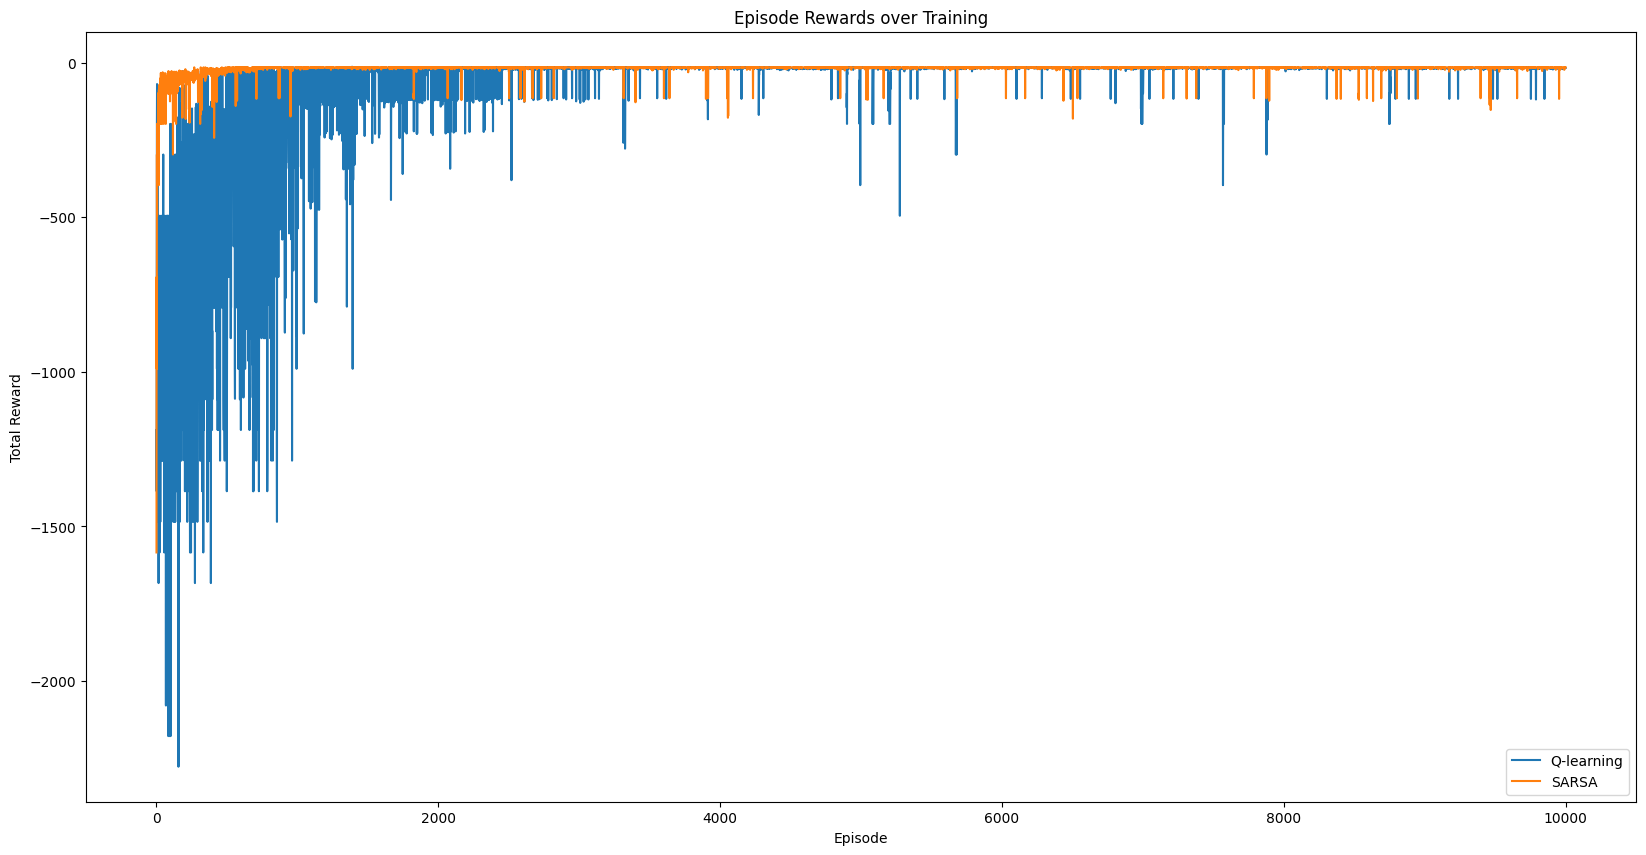

In [ ]:
#Make any plot you desire you to awnser the question you can modify the code of above sections to match your needs

plt.figure(figsize=(20, 10))
plt.plot(episode_rewards_QL, label='Q-learning')
plt.plot(episode_rewards_sarsa, label='SARSA')
plt.title('Episode Rewards over Training')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

# Comparing SARSA with Q-Learning in This Problem
It seems SARSA has a faster convergence to the optimal solution but Q-Learning is more gradual but at last has a better final performance in the given result and has less mistakes after reaching convergence.Now we will compare this two in different terms more clearly:

##Sample Efficent
As we see SARSA seems to be more sample efficient cause it reaches the pi* sooner and needs less samples and number of episodes. One reason can be that SARSA is on-policy and updates its policy with each sample and finds the good policy sooner than Q-learning which is off-policy and uses greedy policy.

##Computational Efficent
Q-Learning is more Computational efficient cause when both algorithms reach the place where they need to specify the Q'(s',a') in the evaluation for the next step to take, in Q learning we use a greedy manner and just calculate the max value for Q(s') and don't look at what action we take but in SARSA we need to specify the action for the next state (s') and then find the Q(s', a').Actually in SARSA we consider resuming our way according to the policy we have but in Q-Learning we just consider the best option for Q(s') so Q-Learning has less overhead overall and computational difficulties.

##Overal Performance Considering the Environment
We can say in this special case Q-learning had better results in final performance although it converged later than SARSA but the final results were more stable and precise.And also SARSA converged sooner but the thing is sometimes environments are far more complicated and with a lot more states and SARSA can get stuck in a local optima but in this special case scenario SARSA also achieved success in finding winning policy and in terms of time and being more sample efficient it had the upper hand.But after all we cannot give a determined interpretation once and for all cause in different environments with different hyperparameters result can vary remarkably.